In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # or the full path to the "project" directory
import numpy as np
import gpbr

In [2]:
from gpbr.direct.common.boundary import Point2D
from gpbr.direct.common.distance import point_distance, matpoint_distance
def u2de(xp, t):
    point = Point2D(0,4)
    dist =point_distance(point, xp)
    return 1/4/np.pi/t*np.exp(-dist**2/4/t)
    

def matu2de(X, t):
    Y = np.zeros_like(X)
    Y[1][:] = 4
    dist = matpoint_distance(X, Y)
    return 1/4/np.pi/t*np.exp(-dist**2/4/t)
    

In [3]:
from gpbr.direct.common.boundary import Point2D

from gpbr.direct.common.boundary import Point2D

def f1(x: Point2D , t: float) -> float:
    return u2de(x, t)

def f2(x: Point2D, t: float) -> float:
    return u2de(x, t)

def matf1(X , t: float) -> float:
    return matu2de(X, t)

def matf2(X, t: float) -> float:
    return matu2de(X, t)

In [4]:
from gpbr.direct.heat_equation.common import MFSConfig
T = 1 # final time
N = 10 # N+1=10 time points
M = 32 # number of collocation and points
# M = 32 # number of collocation and points
ETA1 = 0.5
ETA2 = 2.0
config = MFSConfig(
    N=N,
    n_coll=M,
    n_source=M,
    T=T,
    eta1=ETA1,
    eta2=ETA2,
    f1=f1,
    f2=f2
)

matconfig = MFSConfig(
    N=N,
    n_coll=M,
    n_source=M,
    T=T,
    eta1=ETA1,
    eta2=ETA2,
    f1=matf1,
    f2=matf2
)


In [5]:
from gpbr.direct.heat_equation.helpers import precalculate_mfs_data
mfs_data = precalculate_mfs_data(config)
matmfs_data = precalculate_mfs_data(matconfig)

In [6]:
def r2(s):
    return 0.8

def dr2(s):
    return 0

In [7]:
from gpbr.direct.common.boundary import StarlikeCurve, starlike_circle_base, starlike_curve
Gamma2 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r2, dr2)
Gamma2_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA2*r2(s))


from gpbr.direct.common.boundary import StarlikeCurve, starlike_circle_base, starlike_curve
matGamma2 = StarlikeCurve.from_radial_with_derivative(matmfs_data.collocation, r2, dr2)
matGamma2_source = StarlikeCurve.from_radial(matmfs_data.source_collocation, lambda s: ETA2*r2(s))

In [8]:
from gpbr.direct.common.source import SourcePoints2D
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d
from gpbr.direct.heat_equation.helpers import dbu_2d

from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs
from numpy.linalg import lstsq


def eval_for_g1(
        Gamma2: StarlikeCurve,
        Gamma2_source: StarlikeCurve,
        f1, f2,
        mfs_data,
        r1_func
    ):
    Gamma1 = StarlikeCurve.from_radial(mfs_data.collocation, r1_func)
    Gamma1_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA1*r1_func(s))
    source_points = SourcePoints2D(Gamma1_source.collocation.n+Gamma2_source.collocation.n, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)


    fundamental_sequence_gamma1 = fundamental_sequence_2d(Gamma1, source_points, mfs_data)
    fundamental_sequence_gamma2 = fundamental_sequence_2d(Gamma2, source_points, mfs_data)
    PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)


    alpha_coeeff = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    alpha_coeeff[:] = np.nan
    fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
    for n in range(0, mfs_data.N+1):
        F = form_fs_vector_2d(n,
                            fundamental_sequence_gamma1,
                            fundamental_sequence_gamma2,
                            Gamma1,
                            Gamma2,
                            fs_coefs,
                            f1, f2, mfs_data)
        alpha_n = lstsq(PHI_MAT, F)[0]
        fs_coefs.alpha[n] = alpha_n.T
    # print(fs_coefs.alpha)


    du_vals = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    for n in range(0, N+1):
        for i, (x, nx) in enumerate(zip(Gamma2.points, Gamma2.normals)):
            du_vals[n, i] = dbu_2d(x, nx, n, source_points, fs_coefs, mfs_data)
    return du_vals

    

In [9]:
from gpbr.direct.common.source import SourcePoints2D
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence, matfundamental_sequence_2d
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d, matdbu_2d, matform_fs_vector_2d
from gpbr.direct.heat_equation.helpers import dbu_2d

from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs
from numpy.linalg import lstsq


def mateval_for_g1(
        Gamma2: StarlikeCurve,
        Gamma2_source: StarlikeCurve,
        f1, f2,
        mfs_data,
        r1_func
    ):
    Gamma1 = StarlikeCurve.from_radial(mfs_data.collocation, r1_func)
    Gamma1_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA1*r1_func(s))
    source_points = SourcePoints2D(Gamma1_source.collocation.n+Gamma2_source.collocation.n, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)


    fundamental_sequence_gamma1 = matfundamental_sequence_2d(Gamma1, source_points, mfs_data)
    fundamental_sequence_gamma2 = matfundamental_sequence_2d(Gamma2, source_points, mfs_data)
    PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)

    alpha_coeeff = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    alpha_coeeff[:] = np.nan
    fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
    for n in range(0, mfs_data.N+1):
        F = matform_fs_vector_2d(n,
                            fundamental_sequence_gamma1,
                            fundamental_sequence_gamma2,
                            Gamma1,
                            Gamma2,
                            fs_coefs,
                            f1, f2, mfs_data)
        alpha_n = lstsq(PHI_MAT, F)[0]
        fs_coefs.alpha[n] = alpha_n.T

    # print(fs_coefs.alpha)

    du_vals = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    du_vals[:] = np.nan

    for ni in range(0, N+1):
        du_vals[ni] = matdbu_2d(Gamma2.points_array,Gamma2.normals_array, ni, source_points, fs_coefs, mfs_data).ravel()
    return du_vals


    

In [10]:

def r1(s):
    return np.sqrt(np.cos(s)**2 + np.sin(s)**2/4)

# def r1(s):
#     return (1+0.9*np.cos(s) + 0.1*np.sin(2*s))/(2+1.5*np.cos(s))

exact = eval_for_g1(Gamma2, Gamma2_source, f1, f2, mfs_data, r1)

In [11]:
exact

array([[-1.37454295e-14,  1.22667977e-14,  8.87742760e-14,
         2.75487949e-14, -1.03644332e-13,  5.00225859e-13,
         2.18547259e-12,  3.24267637e-12,  2.18547259e-12,
         5.00225859e-13, -1.03644332e-13,  2.75487949e-14,
         8.87742760e-14,  1.22667977e-14, -1.37454295e-14,
         6.04218162e-15,  4.09956760e-15, -7.12085275e-15,
         7.34983808e-16,  1.11548995e-14,  4.29051216e-15,
        -4.99966426e-15, -1.52134993e-16,  6.01085075e-15,
        -1.52134993e-16, -4.99966426e-15,  4.29051216e-15,
         1.11548995e-14,  7.34983808e-16, -7.12085275e-15,
         4.09956760e-15,  6.04218162e-15],
       [-2.70966241e-09,  7.82832467e-09,  5.88021303e-08,
         1.52090155e-07,  3.52601579e-07,  8.17534648e-07,
         1.53452794e-06,  1.93668290e-06,  1.53452794e-06,
         8.17534648e-07,  3.52601579e-07,  1.52090155e-07,
         5.88021303e-08,  7.82832467e-09, -2.70966241e-09,
         3.74220707e-09,  2.87265386e-09, -2.23730763e-09,
        -3.86

In [12]:
mat_exact = mateval_for_g1(matGamma2, matGamma2_source, matf1, matf2, matmfs_data, r1)
mat_exact

array([[-1.37454295e-14,  1.22667977e-14,  8.87742760e-14,
         2.75487949e-14, -1.03644332e-13,  5.00225859e-13,
         2.18547259e-12,  3.24267637e-12,  2.18547259e-12,
         5.00225859e-13, -1.03644332e-13,  2.75487949e-14,
         8.87742760e-14,  1.22667977e-14, -1.37454295e-14,
         6.04218162e-15,  4.09956760e-15, -7.12085275e-15,
         7.34983808e-16,  1.11548995e-14,  4.29051216e-15,
        -4.99966426e-15, -1.52134993e-16,  6.01085075e-15,
        -1.52134993e-16, -4.99966426e-15,  4.29051216e-15,
         1.11548995e-14,  7.34983808e-16, -7.12085275e-15,
         4.09956760e-15,  6.04218162e-15],
       [-2.70966241e-09,  7.82832467e-09,  5.88021303e-08,
         1.52090155e-07,  3.52601579e-07,  8.17534648e-07,
         1.53452794e-06,  1.93668290e-06,  1.53452794e-06,
         8.17534648e-07,  3.52601579e-07,  1.52090155e-07,
         5.88021303e-08,  7.82832467e-09, -2.70966241e-09,
         3.74220707e-09,  2.87265386e-09, -2.23730763e-09,
        -3.86

In [13]:
np.max(exact-mat_exact)

np.float64(3.881443777498106e-17)

In [14]:
assert False

AssertionError: 

In [ ]:
import matplotlib.pyplot as plt

# def plot_g1(G1):
#     fig_plot, ax_plot = plt.subplots()
#     g1_x, g1_y = G1.raw_points()
#     ax_plot.plot(g1_x, g1_y, 'b--')

#     ax_plot.axis('equal')
#     plt.grid()
#     plt.show()
#     plt.close()

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def plot_g1(G1, title="Starlike Curve", show_normals=False, color='#1f77b4', 
            figsize=(10, 8), dpi=120, save_path=None):
    """
    Plot a starlike curve with enhanced visual presentation.
    
    Parameters:
    -----------
    G1 : StarlikeCurve
        The starlike curve to plot.
    title : str, optional
        Title for the plot.
    show_normals : bool, optional
        Whether to display normal vectors.
    color : str, optional
        Color for the curve.
    figsize : tuple, optional
        Figure size (width, height) in inches.
    dpi : int, optional
        Resolution of the figure.
    save_path : str, optional
        If provided, save the figure to this path.
    """
    # Set up the figure with clean style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Get points and plot with enhanced styling
    g1_x, g1_y = G1.raw_points()
    
    # Plot filled curve with fade
    ax.fill(g1_x, g1_y, color=color, alpha=0.2)
    
    # Plot curve with solid color instead of gradient
    ax.plot(g1_x, g1_y, color=color, linewidth=2.5, alpha=0.8)
    
    # Add a few markers along the curve
    num_markers = 12
    marker_indices = np.linspace(0, len(g1_x)-1, num_markers, dtype=int)
    ax.plot(g1_x[marker_indices], g1_y[marker_indices], 'o', color='navy', 
            markersize=5, alpha=0.8)
    
    # Show normals if requested
    if show_normals and hasattr(G1, 'normals'):
        for i in marker_indices:
            if i < len(G1.points):  # Ensure index is valid
                p = G1.points[i]
                n = G1.normals[i]
                ax.arrow(p.x, p.y, n.x*0.15, n.y*0.15, head_width=0.05, 
                         head_length=0.08, fc='red', ec='red', alpha=0.7)
    
    # Enhance the appearance
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_xlabel('X', fontsize=14)
    ax.set_ylabel('Y', fontsize=14)
    
    # Add legend if showing normals
    if show_normals:
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color=color, lw=2, label='Curve'),
            Line2D([0], [0], marker='o', color='navy', label='Sample Points', 
                  markersize=5, linestyle='None'),
            Line2D([0], [0], color='red', label='Normal Vectors')
        ]
        ax.legend(handles=legend_elements, loc='best')
    
    # Calculate max radius for setting limits
    max_radius = max(np.sqrt(g1_x**2 + g1_y**2))
    
    # Adjust limits with padding
    padding = max_radius * 0.1
    ax.set_xlim([-max_radius-padding, max_radius+padding])
    ax.set_ylim([-max_radius-padding, max_radius+padding])
    
    # Tight layout
    plt.tight_layout()
    
    # Save if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()
    
    return fig, ax

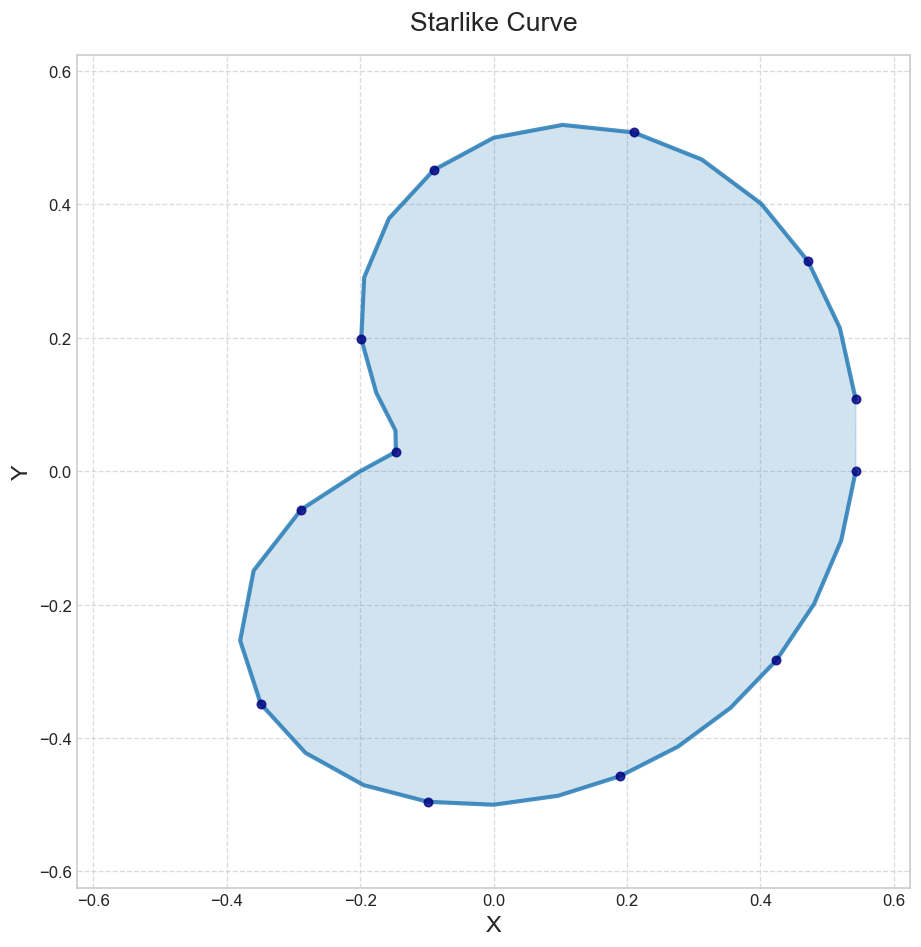

(<Figure size 1200x960 with 1 Axes>,
 <Axes: title={'center': 'Starlike Curve'}, xlabel='X', ylabel='Y'>)

In [ ]:
G1_plot = StarlikeCurve.from_radial(mfs_data.collocation, r1)
plot_g1(G1_plot)

In [ ]:
from scipy import integrate

def calc_l2_norm(ncoll, thetas, tn, exact, approx):
    diff_squared = (approx-exact)**2
    time_inegrals = []
    for i in range(len(tn)):
        time_inegrals.append(integrate.trapezoid(diff_squared[i], thetas))
    
    return integrate.trapezoid(time_inegrals, tn)
    # return np.sqrt(integrate.trapezoid(np.sum((approx-exact)**2, axis=1), tn)*(2*np.pi)/(ncoll))
    return integrate.trapezoid(np.sum((approx-exact)**2, axis=1), tn)*(2*np.pi)/(ncoll)


In [ ]:
def feasable(ext_boundary, rfunc, rvals):
    if abs(rfunc(0) - rfunc(2*np.pi)) > 1e-10:
        return False

    if not np.isfinite(rvals).all():
        return False

    if np.any(np.less(rvals, 0.0)):
        return False

    if np.any(np.greater_equal(rvals, ext_boundary)):
        return False
    
    return True

In [ ]:
import random
from deap import creator, base, tools, algorithms, gp

In [ ]:
import functools
import math, operator

pset = gp.PrimitiveSet("main", 1)
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.cos, 1)
pset.addPrimitive(np.sin, 1)
pset.addPrimitive(np.sqrt, 1)
pset.addEphemeralConstant('rand', (np.random.rand, 1)[0])

pset.renameArguments(ARG0="s")

In [ ]:
import random
from deap import creator, base, tools, algorithms
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [ ]:
toolbox = base.Toolbox()
# toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)

In [ ]:
# toolbox.register('evaluate', eval_for_g1, Gamma2=Gamma2, Gamma2_source=Gamma2_source, f1=f1, f2=f2, mfs_data=mfs_data)
toolbox.register('feasable', feasable, 1.6)
toolbox.register('calc_normals', eval_for_g1, Gamma2, Gamma2_source, f1, f2, mfs_data)
toolbox.register('norm', calc_l2_norm, mfs_data.M,mfs_data.collocation.theta, mfs_data.tn, exact)
toolbox.register('plot', plot_g1)

In [ ]:
def evaluate(mfsd, tlb, ind):
    # print(ind)
    ind_compile = tlb.compile(expr=ind)
    ind_values = ind_compile(mfsd.collocation.theta)
    if not toolbox.feasable(ind_compile, ind_values):
        return (1e6, )

    g2_approx = toolbox.calc_normals(ind_compile)
    return (toolbox.norm(g2_approx), )

In [ ]:
toolbox.register('evaluate', evaluate, mfs_data, toolbox)

In [ ]:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [ ]:

# random.seed(318)

pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.1, 40, stats=mstats,
                            halloffame=hof, verbose=True)

<string>:1: RuntimeWarning: invalid value encountered in sqrt


   	      	                       fitness                        	                     size                     
   	      	------------------------------------------------------	----------------------------------------------
gen	nevals	avg   	gen	max  	min      	nevals	std   	avg 	gen	max	min	nevals	std   
0  	50    	600011	0  	1e+06	0.0647461	50    	489884	6.44	0  	33 	2  	50    	5.8212
1  	43    	240069	1  	1e+06	0.0647461	43    	427045	3.76	1  	34 	1  	43    	4.59809
2  	41    	60030.8	2  	1e+06	0.0631645	41    	237479	2.94	2  	7  	2  	41    	1.43402
3  	43    	60020.7	3  	1e+06	0.0631645	43    	237482	2.18	3  	4  	1  	43    	0.589576
4  	50    	80000.4	4  	1e+06	0.0631645	50    	271293	2.04	4  	3  	1  	50    	0.397995


In [ ]:
print(hof[0])

sin(0.49748570169459816)


In [ ]:
def plot_exact_and_approx(exact_curve, approx_curve, title="Exact vs. Approximate Solution"):
    """
    Plot exact and approximate curves with error visualization.
    
    Parameters:
    -----------
    exact_curve : StarlikeCurve
        The exact solution curve
    approx_curve : StarlikeCurve
        The approximate solution curve
    title : str
        Main title for the plots
        
    Returns:
    --------
    figs : tuple
        Tuple containing the two figure objects
    """
    # Create two separate figures
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    # Get data points
    exact_x, exact_y = exact_curve.raw_points()
    approx_x, approx_y = approx_curve.raw_points()
    
    # Calculate errors at each point
    exact_r = np.sqrt(exact_x**2 + exact_y**2)
    approx_r = np.sqrt(approx_x**2 + approx_y**2)
    abs_error = np.abs(exact_r - approx_r)
    max_error = np.max(abs_error)
    
    # FIGURE 1: Side-by-side comparison
    # Plot exact curve
    ax1.plot(exact_x, exact_y, color='green', linewidth=3, label='Exact')
    ax1.fill(exact_x, exact_y, color='green', alpha=0.2)
    
    # Plot approximate curve
    ax1.plot(approx_x, approx_y, color='red', linewidth=3, label='Approximate')
    ax1.fill(approx_x, approx_y, color='red', alpha=0.2)
    
    # Add markers for better visualization
    num_markers = 8
    marker_indices = np.linspace(0, len(exact_x)-1, num_markers, dtype=int)
    ax1.plot(exact_x[marker_indices], exact_y[marker_indices], 'o', 
             color='darkgreen', markersize=5)
    ax1.plot(approx_x[marker_indices], approx_y[marker_indices], 'o', 
             color='darkred', markersize=5)
    
    # Figure 1 styling
    ax1.set_aspect('equal')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_title(f"{title}\nComparison View", fontsize=14)
    ax1.set_xlabel('X', fontsize=12)
    ax1.set_ylabel('Y', fontsize=12)
    ax1.legend(loc='best')
    
    # FIGURE 2: Error visualization
    # Plot exact curve as reference
    ax2.plot(exact_x, exact_y, color='black', linewidth=2, linestyle='--', 
             alpha=0.7, label='Exact')
    
    # Create a colormap for the error
    norm = plt.Normalize(0, max_error)
    
    # Plot approximate curve colored by error
    # We'll use a LineCollection for coloring by error value
    from matplotlib.collections import LineCollection
    points = np.array([approx_x, approx_y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap='jet', norm=norm, linewidth=4)
    lc.set_array(abs_error)
    line = ax2.add_collection(lc)
    
    # Add a colorbar
    cbar = fig2.colorbar(line, ax=ax2)
    cbar.set_label('Absolute Error')
    
    # Figure 2 styling
    ax2.set_aspect('equal')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_title(f"{title}\nError Visualization", fontsize=14)
    ax2.set_xlabel('X', fontsize=12)
    ax2.set_ylabel('Y', fontsize=12)
    
    # Set axis limits for both plots based on the maximum extent
    max_radius = max(
        np.max(np.sqrt(exact_x**2 + exact_y**2)),
        np.max(np.sqrt(approx_x**2 + approx_y**2))
    )
    padding = max_radius * 0.1
    
    for ax in [ax1, ax2]:
        ax.set_xlim([-max_radius-padding, max_radius+padding])
        ax.set_ylim([-max_radius-padding, max_radius+padding])
    
    # Create a custom legend for the second plot
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', linestyle='--', lw=2, label='Exact Curve'),
        Line2D([0], [0], color='red', lw=2, label='Approximate (Error Colored)')
    ]
    ax2.legend(handles=legend_elements, loc='best')
    
    # Apply tight layout
    fig1.tight_layout()
    fig2.tight_layout()
    
    plt.show()
    
    return (fig1, fig2)

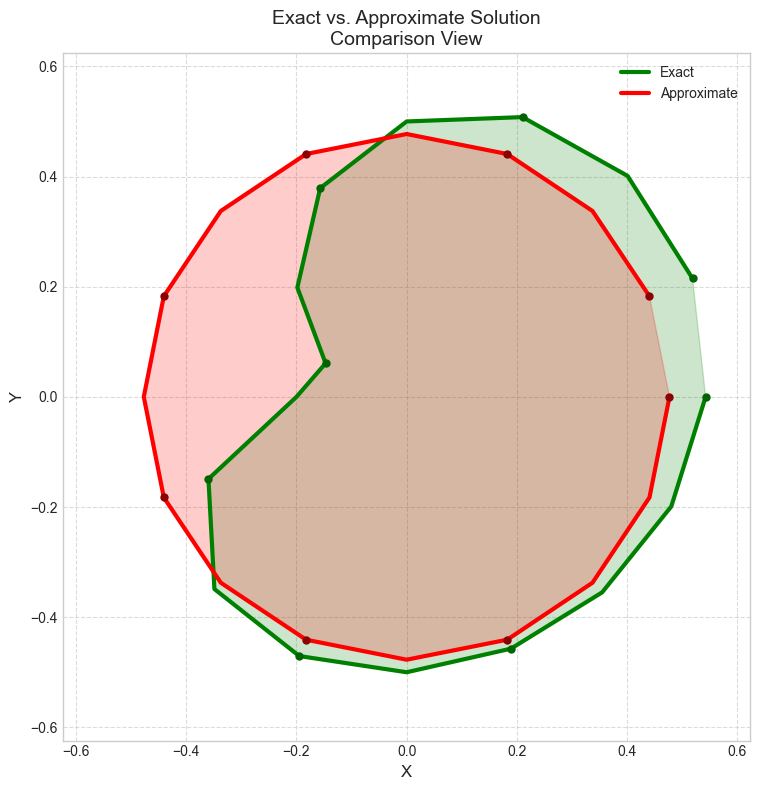

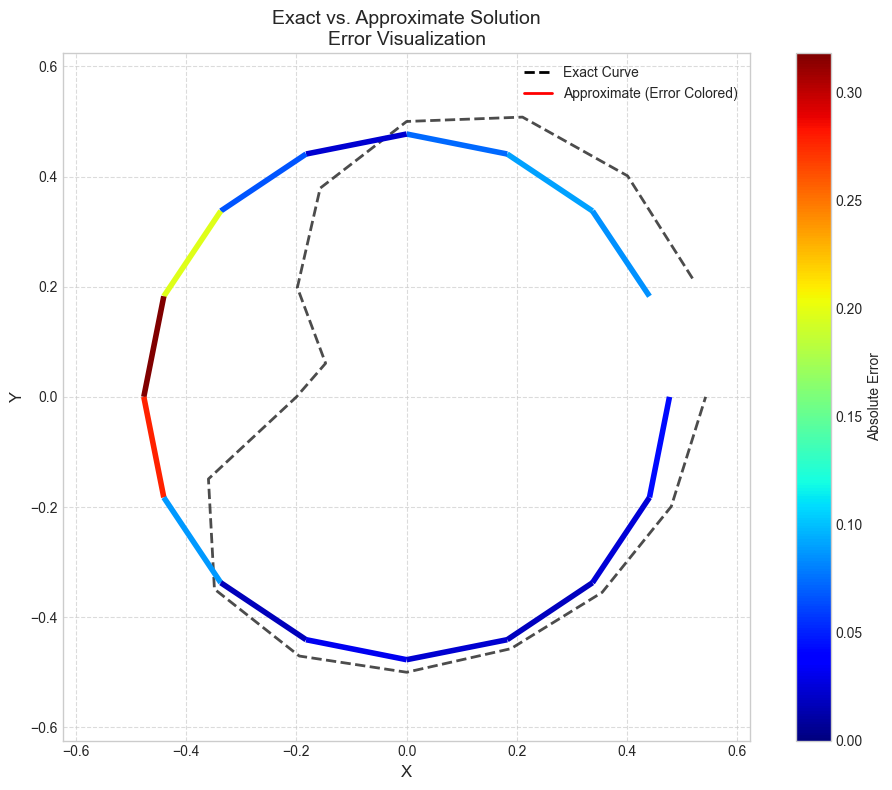

(<Figure size 1000x800 with 1 Axes>, <Figure size 1000x800 with 2 Axes>)

In [ ]:

G1_test = StarlikeCurve.from_radial(mfs_data.collocation, toolbox.compile(expr=hof[0]))
plot_exact_and_approx(G1_plot, G1_test, title="Exact vs. Approximate Solution")

In [ ]:
# G1_test = StarlikeCurve.from_radial(mfs_data.collocation, toolbox.compile(expr=hof[0]))
# toolbox.plot(G1_test)

In [ ]:
print(hof[0])

cos(sin(s))


In [ ]:
def plot_evolution_stats(log, title="Evolutionary Algorithm Performance", figsize=(15, 10)):
    """
    Visualize the evolutionary process based on DEAP's MultiStatistics log.
    
    Parameters:
    -----------
    log : DEAP logbook
        The logbook returned by DEAP's algorithms (eaSimple, eaMuPlusLambda, etc.)
    title : str, optional
        Main title for the plots
    figsize : tuple, optional
        Figure size (width, height) in inches
        
    Returns:
    --------
    fig : matplotlib Figure
        The figure object containing all subplots
    """
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    
    # Convert log to dataframe for easier manipulation
    gen = log.select("gen")
    
    # Create figure with custom layout
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])
    
    # Extract statistics
    fit_mins = log.chapters["fitness"].select("min")
    fit_avgs = log.chapters["fitness"].select("avg")
    fit_maxs = log.chapters["fitness"].select("max")
    fit_stds = log.chapters["fitness"].select("std")
    
    size_avgs = log.chapters["size"].select("avg")
    size_mins = log.chapters["size"].select("min")
    size_maxs = log.chapters["size"].select("max")
    size_stds = log.chapters["size"].select("std")
    
    # Plot 1: Fitness Trend (with confidence interval)
    ax1 = plt.subplot(gs[0, :])
    ax1.plot(gen, fit_avgs, 'b-', label='Average Fitness', linewidth=2)
    ax1.plot(gen, fit_mins, 'g-', label='Best Fitness', linewidth=2)
    ax1.fill_between(gen, 
                     [a - b for a, b in zip(fit_avgs, fit_stds)],
                     [a + b for a, b in zip(fit_avgs, fit_stds)],
                     alpha=0.2, color='blue', label='Std Dev')
    
    # Add annotations for best fitness
    best_gen = fit_mins.index(min(fit_mins))
    best_fit = min(fit_mins)
    ax1.annotate(f'Best: {best_fit:.4f}',
                xy=(best_gen, best_fit), xycoords='data',
                xytext=(best_gen + 2, best_fit), textcoords='data',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=1, alpha=0.8))
    
    ax1.set_title('Fitness Evolution', fontsize=14)
    ax1.set_xlabel('Generation', fontsize=12)
    ax1.set_ylabel('Fitness Value', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc='upper right')
    
    # Plot 2: Solution Size Evolution
    ax2 = plt.subplot(gs[1, 0])
    ax2.plot(gen, size_avgs, 'm-', label='Average Size', linewidth=2)
    ax2.plot(gen, size_mins, 'c-', label='Min Size', linewidth=1.5)
    ax2.plot(gen, size_maxs, 'y-', label='Max Size', linewidth=1.5)
    
    ax2.set_title('Solution Size Evolution', fontsize=14)
    ax2.set_xlabel('Generation', fontsize=12)
    ax2.set_ylabel('Tree Size', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(loc='upper right')
    
    # Plot 3: Size vs. Fitness Correlation
    ax3 = plt.subplot(gs[1, 1])
    sc = ax3.scatter(size_avgs, fit_avgs, c=gen, cmap='viridis', 
                    s=50, edgecolor='k', alpha=0.7)
    
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax3)
    cbar.set_label('Generation')
    
    # Add arrows to show progression
    for i in range(1, len(gen)):
        ax3.annotate('',
                    xy=(size_avgs[i], fit_avgs[i]),
                    xytext=(size_avgs[i-1], fit_avgs[i-1]),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1, alpha=0.5))
    
    ax3.set_title('Size-Fitness Correlation', fontsize=14)
    ax3.set_xlabel('Average Solution Size', fontsize=12)
    ax3.set_ylabel('Average Fitness', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    # Main title
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
    
    return fig

In [ ]:
plot_evolution_stats(log)

In [ ]:
assert False

AssertionError: 

In [ ]:
import matplotlib.pyplot as plt

def plot_g1(G1):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
toolbox.register('plot', plot_g1)

add(sin(cos(sin(sin(s)))), sin(add(sin(add(0.35154652343713955, s)), cos(multiply(s, s)))))
multiply(s, s)
multiply(sin(multiply(cos(sin(s)), cos(sin(0.6149477194972331)))), cos(multiply(multiply(sin(0.5180465030210641), sin(0.04959337865745339)), add(cos(0.7573324363233912), cos(s)))))
1.552991909080186e-05


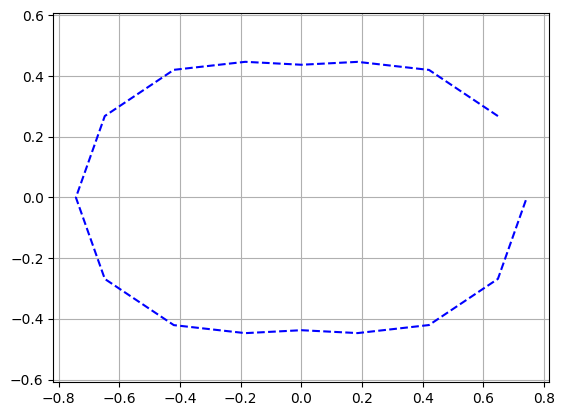

---------------------------------------------------------------------------
sin(add(0.12037073509728358, s))
multiply(cos(sin(sin(s))), sin(cos(multiply(0.9350739033069126, s))))
multiply(0.30813773366873853, multiply(s, 0.5089915652036325))
sin(multiply(sin(sin(s)), cos(sin(0.7359000640387753))))
sin(cos(s))
cos(cos(sin(multiply(add(s, 0.3677084696698829), cos(0.10533105821766908)))))
multiply(cos(sin(add(add(0.2638132373849562, s), add(0.10490388560245512, s)))), add(cos(multiply(cos(s), cos(0.2460418822655981))), sin(cos(cos(0.014921757807564773)))))
4.5364073068500464e-05


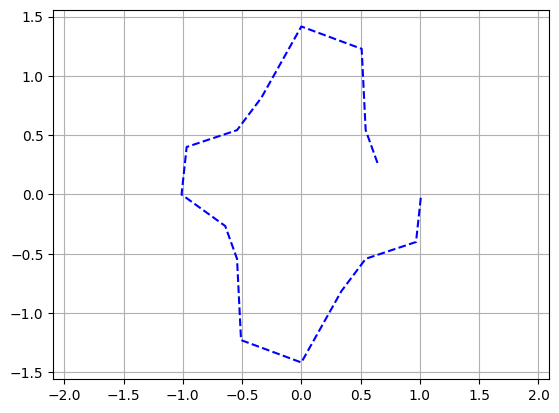

---------------------------------------------------------------------------
cos(multiply(s, 0.3100523103549573))
sin(cos(cos(0.9222110602541755)))
5.2655661052626634e-06


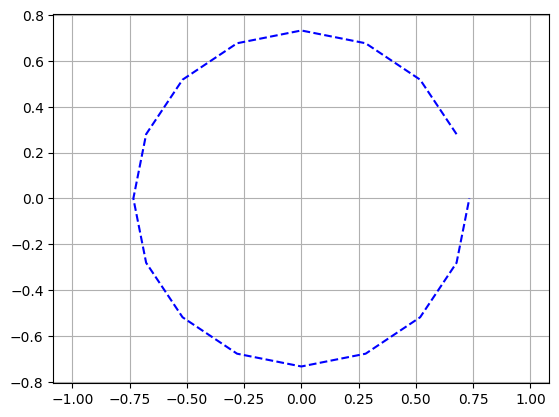

---------------------------------------------------------------------------
add(cos(cos(multiply(s, s))), cos(cos(add(s, s))))
add(add(0.2611738351753442, 0.6121529504174111), cos(0.9793584348178721))
0.0005761421736524605


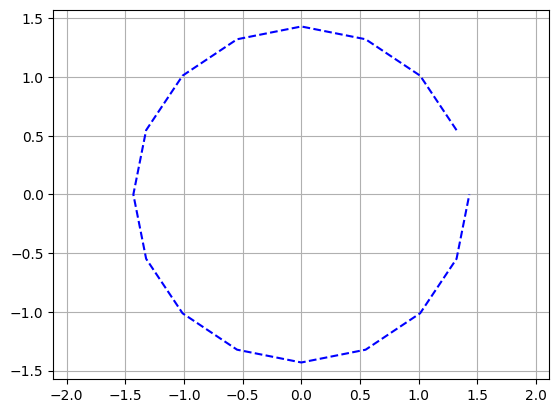

---------------------------------------------------------------------------
add(cos(add(cos(s), multiply(s, s))), sin(sin(sin(s))))
multiply(multiply(add(cos(multiply(0.6669384554290868, s)), add(sin(s), add(s, s))), add(add(multiply(0.5176719646519707, 0.39932071098154875), sin(0.5059969639592864)), sin(add(s, 0.5311130120151062)))), add(cos(add(add(s, s), add(0.3360314517930926, 0.9762579352641558))), cos(multiply(add(s, s), multiply(s, s)))))
sin(s)
sin(cos(s))
sin(0.2247570555588566)
1.8560087625195784e-05


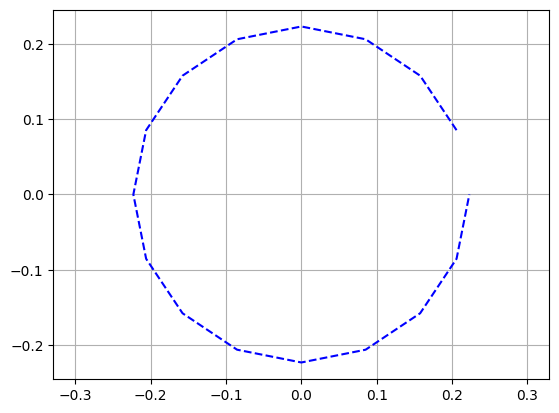

---------------------------------------------------------------------------
cos(sin(sin(multiply(0.07063018514010444, s))))
multiply(0.23193011712783884, s)
multiply(add(sin(add(add(0.2869928392479212, 0.38413556245851455), add(0.2552412992449399, 0.17387039993720643))), cos(add(add(0.32301124823684824, 0.8400653216479955), multiply(0.7439388735838811, s)))), add(cos(sin(multiply(0.2913194259331081, 0.5486672013021568))), cos(cos(add(s, 0.1048308758173726)))))
sin(s)
add(sin(sin(0.9371961008138076)), add(cos(s), add(0.7380477674822958, s)))
add(sin(multiply(cos(add(0.8658354152708848, s)), add(multiply(0.569574066766192, s), sin(s)))), multiply(sin(sin(sin(0.3227334007824313))), cos(multiply(cos(0.8650242575779415), add(s, s)))))
multiply(sin(s), sin(s))
7.204022212542782e-06


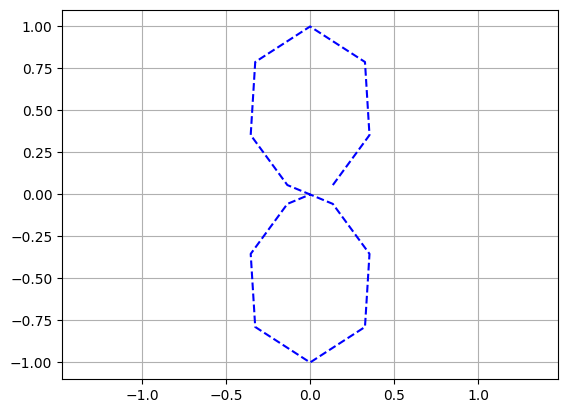

---------------------------------------------------------------------------
sin(s)
sin(s)
cos(0.11345235045793656)
2.6386411681343252e-05


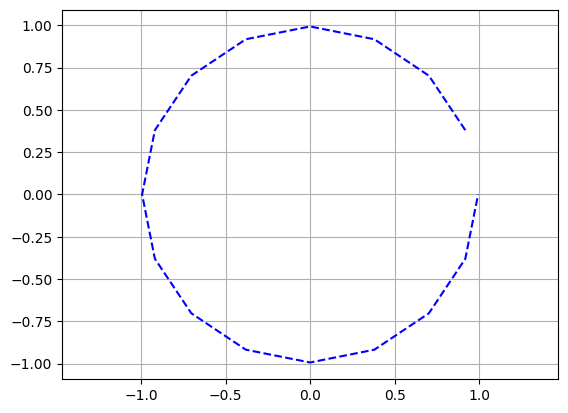

---------------------------------------------------------------------------
sin(s)
sin(s)
sin(multiply(cos(0.296752823510109), multiply(multiply(s, 0.686582019226399), add(s, 0.3039228594036216))))
multiply(sin(sin(add(add(0.361565926237704, s), sin(s)))), sin(add(cos(add(s, 0.8748001286585986)), add(multiply(0.7717659769299718, 0.4902974811827907), cos(0.8221172444727883)))))
add(0.18616114508721093, multiply(s, 0.3590137773722407))
add(sin(cos(s)), cos(multiply(0.23563309516326048, s)))
multiply(s, s)
add(0.09660511852276721, sin(cos(0.866260916398649)))
7.40417016959267e-06


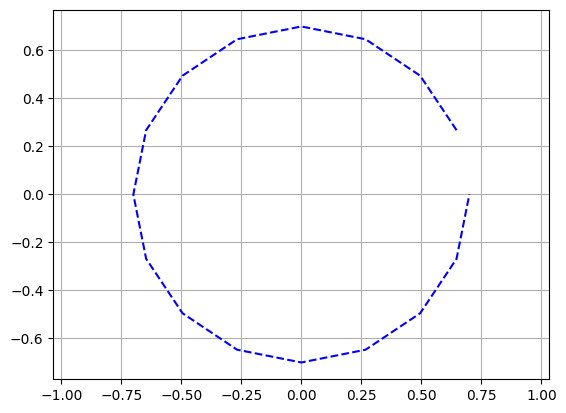

---------------------------------------------------------------------------
add(cos(sin(0.9508048925802135)), s)
multiply(add(sin(s), add(s, 0.493843121351071)), add(add(s, s), sin(0.30927110591223195)))
multiply(sin(s), multiply(s, 0.9787066940900057))
sin(multiply(s, s))
add(cos(s), add(sin(s), sin(add(s, 0.7970850234640509))))
cos(s)
cos(0.7130791641665306)
3.5984995114309576e-06


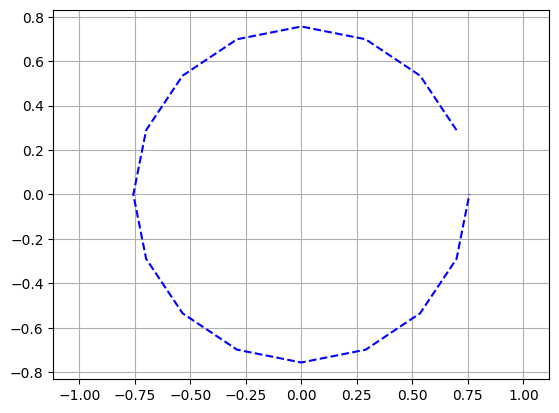

---------------------------------------------------------------------------
multiply(add(multiply(cos(cos(0.3772565565794904)), cos(multiply(0.052206353644035475, 0.4877777538655037))), sin(cos(cos(s)))), multiply(add(cos(cos(0.4040309467767673)), cos(multiply(0.16730545174759037, s))), add(sin(cos(0.8932669594490584)), add(add(0.057518431890260624, s), cos(0.74848928074168)))))
add(cos(s), multiply(s, s))
multiply(add(multiply(sin(sin(0.13951586845256347)), add(cos(0.5376215812145829), sin(s))), add(sin(sin(s)), add(sin(s), cos(s)))), sin(multiply(sin(multiply(s, 0.8373884974810512)), cos(add(s, s)))))
cos(sin(sin(0.032811890774947394)))
2.7575424503907682e-05


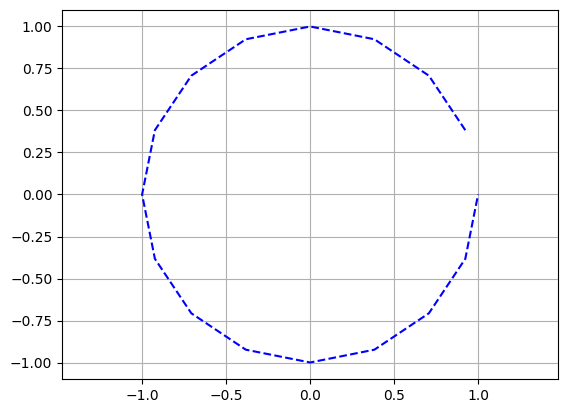

---------------------------------------------------------------------------
cos(s)
add(sin(s), cos(s))


In [ ]:
from scipy import integrate
for ind in toolbox.population(n=50):
    ind_compile = toolbox.compile(expr=ind)
    ind_values = ind_compile(mfs_data.collocation.theta)
    print(ind)

    if not toolbox.feasable(ind_compile, ind_values):
        continue

    G1_test = StarlikeCurve.from_radial(mfs_data.collocation, ind_compile)
    g1_approx = toolbox.evaluate(ind_compile)
    print(toolbox.norm(g1_approx))
    toolbox.plot(G1_test)
    print('---------------------------------------------------------------------------')

In [ ]:
assert False

NameError: name 'Fals' is not defined

In [ ]:
import numpy as np

# Define the parametric function r(theta)
def r(theta):
    return np.sin(theta) + np.sin(0.11352607057693409)
    return np.sin(np.cos(2*theta))
    # sin(cos(add(s, s)))

    # Example: r(theta) = 1 + 0.5 * np.sin(5 * theta)
    return 1 + 0.5 * np.sin(5 * theta)

# Define the number of samples
num_samples = 1000

# Generate theta values
theta_values = np.linspace(0, 2 * np.pi, num_samples)

# Convert to Cartesian coordinates
x_values = r(theta_values) * np.cos(theta_values)
y_values = r(theta_values) * np.sin(theta_values)

# Check for intersections
tolerance = 1e-6
intersections = []

for i in range(num_samples):
    for j in range(i + 1, num_samples):
        if np.abs(x_values[i] - x_values[j]) < tolerance and np.abs(y_values[i] - y_values[j]) < tolerance:
            intersections.append((theta_values[i], theta_values[j]))

print("Self-intersections:", intersections)

Self-intersections: [(np.float64(0.0), np.float64(6.283185307179586))]


In [ ]:
import sympy as sp

# Define the parameter
theta = sp.symbols('theta')

# Define the parametric equations for the starlike curve
r = sp.Function('r')(theta)
x = r * sp.cos(theta)
y = r * sp.sin(theta)

# Define another parameter for comparison
theta2 = sp.symbols('theta2')

# Equations for self-intersection
eq1 = sp.Eq(x.subs(theta, theta), x.subs(theta, theta2))
eq2 = sp.Eq(y.subs(theta, theta), y.subs(theta, theta2))

print("Equation 1:", eq1)
print("Equation 2:", eq2)

Equation 1: Eq(r(theta)*cos(theta), r(theta2)*cos(theta2))
Equation 2: Eq(r(theta)*sin(theta), r(theta2)*sin(theta2))


In [ ]:
ind = toolbox.individual()
print(ind)

sin(cos(cos(-0.12333206376883887)))


In [ ]:
toolbox.compile(ind)(0)

0.5198524963998898

In [ ]:
G1_test = StarlikeCurve.from_radial(mfs_data.collocation, toolbox.compile(ind))

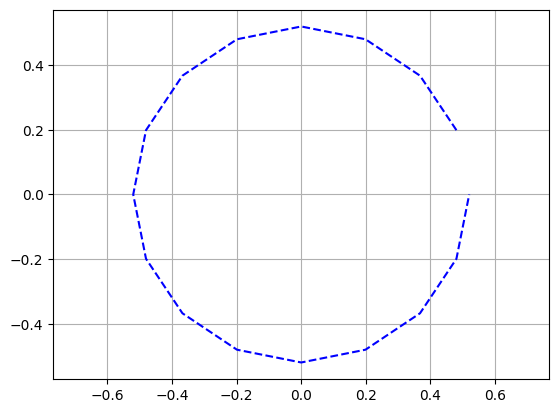

In [ ]:
import matplotlib.pyplot as plt

fig_plot, ax_plot = plt.subplots()
g1_x, g1_y = G1_test.raw_points()
ax_plot.plot(g1_x, g1_y, 'b--')

ax_plot.axis('equal')
plt.grid()
plt.show()
plt.close()

In [ ]:
toolbox.evaluate(toolbox.compile(ind))[0]

array([-9.05432844e-09, -3.93603090e-08,  1.10901463e-07,  5.08693740e-07,
        1.10901463e-07, -3.93603090e-08, -9.05432844e-09,  4.62317030e-09,
        1.03377094e-09, -5.54408448e-10, -1.07784648e-10,  1.29111809e-10,
       -1.07784648e-10, -5.54408448e-10,  1.03377094e-09,  4.62317030e-09])

In [ ]:
def r1(s):
    return 0.8

In [ ]:
def r1(s):
    return 0.8
exact = eval_for_g1(Gamma2, Gamma2_source, f1, f2, mfs_data, r1)

In [ ]:
np.linalg.norm(toolbox.evaluate(toolbox.compile(ind))-res)

np.float64(8.227235313857608e-05)

In [ ]:
assert False

AssertionError: 

In [ ]:
from gpbr.direct.common.boundary import StarlikeCurve, starlike_circle_base, starlike_curve
Gamma1 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r1, dr1)
Gamma2 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r2, dr2)

In [ ]:
Gamma1_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA1*r1(s))
Gamma2_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA2*r2(s))

In [ ]:
from gpbr.direct.common.source import SourcePoints2D
source_points = SourcePoints2D(Gamma1_source.collocation.n+Gamma2_source.collocation.n, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)

In [ ]:
## Plot
import matplotlib.pyplot as plt
def plot_2d(G1: StarlikeCurve, G2: StarlikeCurve, source):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    g2_x, g2_y = G2.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')
    ax_plot.plot(g2_x, g2_y, 'r--')

    for sp in source:
        ax_plot.plot(sp.x, sp.y, 'bo')

    # Plot normal vectors
    for p, n in zip(G1.points, G1.normals):
        ax_plot.quiver(p.x, p.y, n.x, n.y, color='blue', scale=15)

    for p, n in zip(G2.points, G2.normals):
        ax_plot.quiver(p.x, p.y, n.x, n.y, color='red', scale=15)

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()

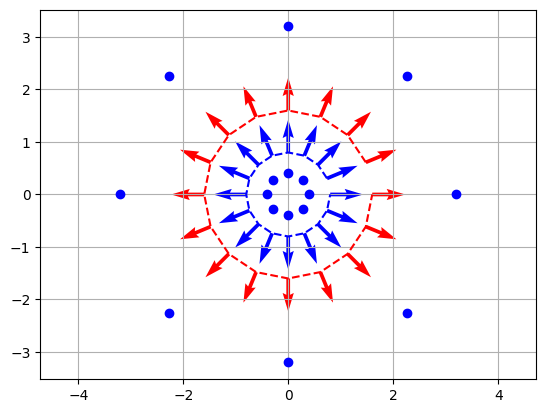

In [ ]:
plot_2d(Gamma1, Gamma2, source_points)

In [ ]:
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence

fundamental_sequence_gamma1 = fundamental_sequence_2d(Gamma1, source_points, mfs_data)
fundamental_sequence_gamma2 = fundamental_sequence_2d(Gamma2, source_points, mfs_data)

In [ ]:
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d
PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)
PHI_MAT.shape

(32, 16)

In [ ]:
PHI_MAT

array([[3.23010230e-06, 2.73551713e-07, 1.52446781e-08, 2.58827313e-09,
        2.58827313e-09, 1.52446781e-08, 2.73551713e-07, 3.23010230e-06,
        9.56681371e-02, 1.97206881e-02, 4.62463023e-03, 2.06453154e-03,
        2.06453154e-03, 4.62463023e-03, 1.97206881e-02, 9.56681371e-02],
       [4.77387264e-06, 1.13397585e-06, 6.03684693e-08, 5.15584128e-09,
        2.04417089e-09, 5.15584128e-09, 6.03684693e-08, 1.13397585e-06,
        1.32712453e-01, 4.56599531e-02, 8.97493161e-03, 2.81006458e-03,
        1.86004541e-03, 2.81006458e-03, 8.97493161e-03, 4.56599531e-02],
       [3.23010230e-06, 3.23010230e-06, 2.73551713e-07, 1.52446781e-08,
        2.58827313e-09, 2.58827313e-09, 1.52446781e-08, 2.73551713e-07,
        9.56681371e-02, 9.56681371e-02, 1.97206881e-02, 4.62463023e-03,
        2.06453154e-03, 2.06453154e-03, 4.62463023e-03, 1.97206881e-02],
       [1.13397585e-06, 4.77387264e-06, 1.13397585e-06, 6.03684693e-08,
        5.15584128e-09, 2.04417089e-09, 5.15584128e-09, 6.036

In [ ]:
from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs

alpha_coeeff = np.empty((N+1, M), dtype=np.float64)
alpha_coeeff[:] = np.nan
fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
from numpy.linalg import lstsq
for n in range(0, N+1):
    F = form_fs_vector_2d(n,
                          fundamental_sequence_gamma1,
                          fundamental_sequence_gamma2,
                          Gamma1,
                          Gamma2,
                          fs_coefs,
                          f1, f2, mfs_data)
    alpha_n = lstsq(PHI_MAT, F)[0]
    fs_coefs.alpha[n] = alpha_n.T
    print(fs_coefs.alpha)

[[-3.44641541e-05  4.11424213e-04 -3.44641541e-05  3.96950906e-06
  -4.74538782e-07  1.10469035e-07 -4.74538782e-07  3.96950906e-06
   3.17577496e-09 -1.72032226e-08  3.17577496e-09  1.06793030e-10
  -6.24306943e-11  1.72986657e-10 -6.24306944e-11  1.06793030e-10]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
       

In [ ]:
from gpbr.direct.common.boundary import Point2D
test_points = [Point2D(0.0, 0.98), Point2D(1.0, -0.73), Point2D(0.51, 0.54), Point2D(-0.501, 0.52), Point2D(-1.11, -0.75), Point2D(0.0, -1.0)]

In [ ]:
from gpbr.direct.heat_equation.helpers import u_2d
for n in range(0, N+1):
    print(f'N={n}')
    for p in test_points:
        u_approx = u_2d(p, n, source_points, fs_coefs, mfs_data)
        u_exact = u2de(p, mfs_data.tn[n])
        print(f'Difference: {abs(u_approx - u_exact)}')
        # print(f'u_approx={u_approx}, u_exact={u_exact}')

N=0
Difference: 3.9066794856549646e-09
Difference: 8.51513042226721e-12
Difference: 1.4972768660576572e-10
Difference: 1.784626575871667e-10
Difference: 1.6793872784732295e-11
Difference: 1.2189477131944364e-12
N=1
Difference: 4.637200256570756e-06
Difference: 4.082887220502182e-09
Difference: 2.7556587717559586e-07
Difference: 3.606114036715847e-07
Difference: 8.013144333423416e-09
Difference: 1.0340333348292328e-09
N=2
Difference: 1.6954070569315163e-05
Difference: 8.941498587993755e-10
Difference: 2.359846584382767e-06
Difference: 3.3125333428670937e-06
Difference: 5.1627702874703165e-09
Difference: 8.369990591347335e-09
N=3
Difference: 3.1544692111930696e-06
Difference: 1.4359394240284083e-07
Difference: 2.7907566271862574e-06
Difference: 3.983583734547264e-06
Difference: 3.1924337417955055e-07
Difference: 1.706349759139021e-08
N=4
Difference: 1.4350362108491192e-05
Difference: 7.250690113106045e-07
Difference: 1.7767428816745155e-07
Difference: 3.5547598110902525e-07
Difference: 1

In [ ]:
def du2de_vec(xp, t):
    # -0.125*x1*exp((-x1**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)
    # 0.25*(2 - x2/2)*exp((-x1**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)
    return Point2D(
        -0.125*xp.x*np.exp((-xp.x**2/4 - (xp.y - 4)**2/4)/t)/(np.pi*t**2),
        0.25*(2 - xp.y/2)*np.exp((-xp.x**2/4 - (xp.y  - 4)**2/4)/t)/(np.pi*t**2)
    )
    

In [ ]:
from gpbr.direct.heat_equation.helpers import dbu_2d
for n in range(0, N+1):
    print(f'N={n}')
    norms = []
    for x, nx in zip(Gamma1.points, Gamma1.normals):
        du_approx = dbu_2d(x, nx, n, source_points, fs_coefs, mfs_data)
        du_e_vec = du2de_vec(x, mfs_data.tn[n])
        du_exact = du_e_vec.x*nx.x + du_e_vec.y*nx.y
        norms.append(abs(du_approx - du_exact))
    print(f'Max difference: {max(norms)}')
    # print(f'Max difference: {np.linalg.norm(norms)}')

N=0
Max difference: 2.1293264769387242e-08
N=1
Max difference: 2.7373373781358973e-05
N=2
Max difference: 0.00012213307444786914
N=3
Max difference: 4.7619616816044685e-05
N=4
Max difference: 0.00013522181580476146
N=5
Max difference: 0.0001845660403924994
N=6
Max difference: 0.00018640978710150226
N=7
Max difference: 0.00017117954795992704
N=8
Max difference: 0.0001488915819131357
N=9
Max difference: 0.00013303996453409468
N=10
Max difference: 0.00011486626441451452
